In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re

from pyspark.sql import SparkSession
from pyspark.shell import spark
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/10/08 22:45:02 WARN Utils: Your hostname, Polaris resolves to a loopback address: 127.0.1.1; using 172.21.131.106 instead (on interface eth0)
22/10/08 22:45:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/08 22:45:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.3.0
      /_/

Using Python version 3.8.10 (default, Jun 22 2022 20:18:18)
Spark context Web UI available at http://172.21.131.106:4040
Spark context available as 'sc' (master = local[*], app id = local-1665229504834).
SparkSession available as 'spark'.
22/10/08 22:45:05 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
monthly_data_df = spark.read.parquet('../data/curated/merchant_monthly_sales')

In [3]:
monthly_data_df.head(5)

[Row(merchant_abn=76767266140, order_month=10, order_year=2021, sales_revenue=474775.29981215525, num_orders=2218, discounted_sales_revenue=442752.88030585117, approximate_fraudulent_orders=146.17635035934018),
 Row(merchant_abn=51221851716, order_month=7, order_year=2021, sales_revenue=423.1366894513822, num_orders=18, discounted_sales_revenue=395.3835509096228, approximate_fraudulent_orders=1.1530352184143875),
 Row(merchant_abn=86578477987, order_month=5, order_year=2021, sales_revenue=421536.9555053424, num_orders=12023, discounted_sales_revenue=395115.6001930482, approximate_fraudulent_orders=749.3187413658477),
 Row(merchant_abn=66079287213, order_month=11, order_year=2021, sales_revenue=74098.80712409382, num_orders=1325, discounted_sales_revenue=69280.69386019278, approximate_fraudulent_orders=85.34816584845879),
 Row(merchant_abn=30389290864, order_month=8, order_year=2021, sales_revenue=59970.731683154445, num_orders=568, discounted_sales_revenue=56086.75802877634, approximat

In [4]:
two_abns_df = monthly_data_df.where(
    F.col('merchant_abn').isin([78916025936, 36758807067])
).withColumn(
    'year_month',
    F.format_string('%d-%02d', 'order_year', 'order_month')
)
two_abns_df

merchant_abn,order_month,order_year,sales_revenue,num_orders,discounted_sales_revenue,approximate_fraudulent_orders,year_month
36758807067,10,2021,1000.0473491632412,18,935.5269312518756,1.1559422188389994,2021-10
36758807067,3,2022,1217.1763031854964,17,1138.3842502846687,1.0864624791144397,2022-03
36758807067,6,2021,922.6355093435778,17,865.5450597676299,1.046413306613753,2021-06
78916025936,10,2021,2064.0370220224804,7,1920.6896227647196,0.4699328561334517,2021-10
78916025936,1,2022,498.5479266675171,2,465.0205563583551,0.13159026344470123,2022-01
78916025936,5,2021,864.4252321511935,4,807.4912084469139,0.2578809808691624,2021-05
36758807067,12,2021,1721.5471710987626,26,1612.1476766343783,1.6301820295642526,2021-12
36758807067,4,2021,1454.062723275021,20,1363.2013617560917,1.240893526884592,2021-04
78916025936,10,2022,173.25623190633792,1,162.17760028873644,0.0639436255521855,2022-10
78916025936,9,2022,382.82117282068407,2,354.92631307187617,0.1462311852768181,2022-09


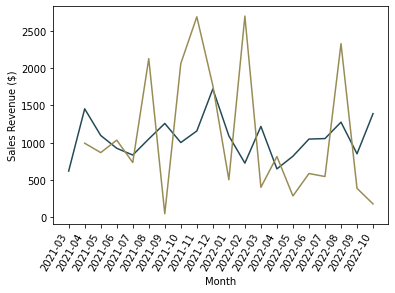

In [19]:
two_abns_pdf = two_abns_df.toPandas().sort_values(
    ['merchant_abn', 'year_month']
)

rev_v_month_plt = sns.lineplot(
    x = 'year_month', 
    y = "sales_revenue",
    hue = 'merchant_abn',
    palette=['#234a55','#988c55'],
    data = two_abns_pdf #[two_abns_pdf['year_month'] != '2021-02']
)
plt.xlabel('Month')
plt.ylabel('Sales Revenue (AUD)')
# plt.title('How sales revenue changes monthly between high and low variance')
plt.xticks(rotation=60, ha='right')
plt.yticks(rotation=0)
plt.legend().set_visible(False)
# plt.legend(['Merchant 1', 'Merchant 2'], loc='upper left')
rev_v_month_plt.figure.savefig(f'../plots/revenue-vs-month-78916025936-36758807067.png', 
        bbox_inches = 'tight', dpi = 500)